Note:
Agentic system is autonomous, making decision and taking actions based on the context of the interactions.

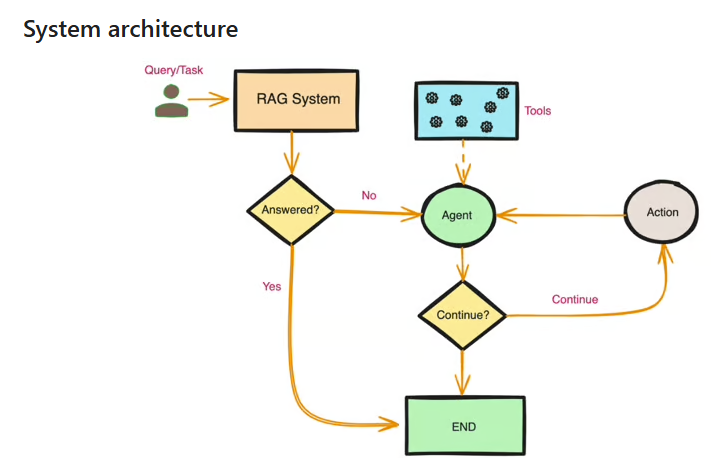

In [1]:
from IPython.display import Image
Image(filename="D:/GENAI_SELF_LEARNING_PYTHON_PROJECTS/agentic_rag/Screenshot 2024-12-16 101642.png") 

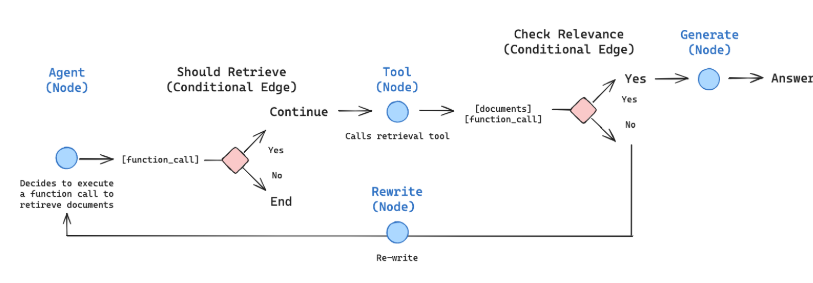

In [2]:
Image(filename="D:/GENAI_SELF_LEARNING_PYTHON_PROJECTS/agentic_rag/Screenshot 2024-12-16 101735.png") 

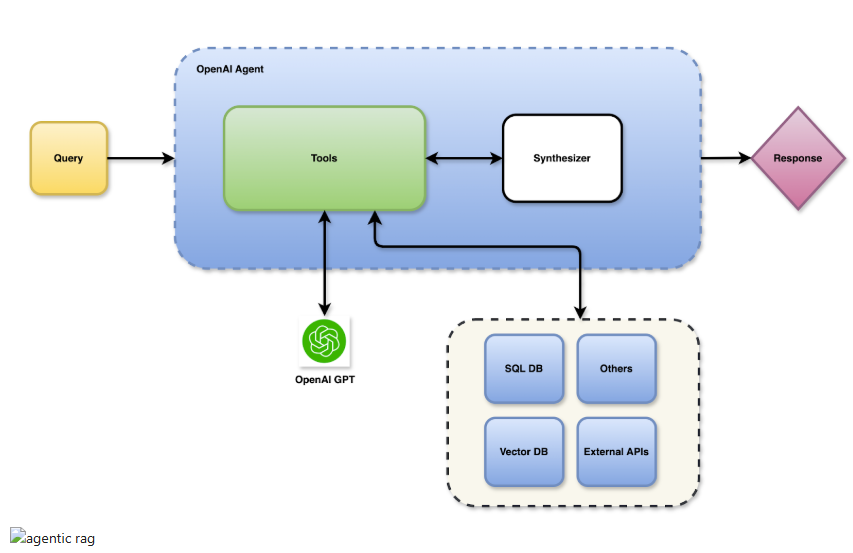

In [3]:
Image(filename="D:/GENAI_SELF_LEARNING_PYTHON_PROJECTS/agentic_rag/Screenshot 2024-12-16 101808.png") 

# Flow chart for this application

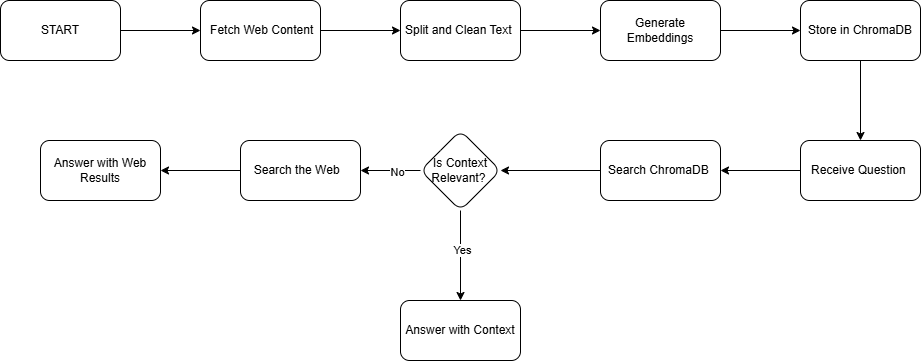

In [26]:
Image(filename="D:/GENAI_SELF_LEARNING_PYTHON_PROJECTS/agentic_rag/Untitled Diagram.drawio.png") 

In [4]:
import os
import PyPDF2
from tqdm.notebook import tqdm
import re
import json

# function to read a folder of pdf files

In [5]:
def read_pdfs_from_folder(folder_path):
    pdf_list = []
    
    # Loop all files in the specified folder
    # tqdm is a popular Python library that helps you add progress bars to your loops and iterables. It's a great way to make your long-running tasks more user-friendly by providing visual feedback on their progress.
    for filename in tqdm(os.listdir(folder_path)):
        if filename.endswith('.pdf'):
            file_path = os.path.join(folder_path, filename)
            
            # open each PDF file
            with open(file_path, 'rb') as file:
                reader = PyPDF2.PdfReader(file)
                content = ""
                
                # Read each page's content and append it to a string
                for page_num in range(len(reader.pages)):
                    page = reader.pages[page_num]
                    content += page.extract_text()
                    
                # Add the PDF content to the list
                pdf_list.append({"content": content, "filename": filename})  
                
    return pdf_list

folder_path = "./rag_data"
         

# Function to Read Web URLs

We used to read web URLs to introduce a new tool called jina. we could have use beautifulsoup or http requests to get the http content and kind of clean the content.


With Jina, we dont need any api , we just need a url and concatenate with jina so that when we do a http call we get the output as a markdown format which is a very human readable content. the jina will remove all the nav bars etc.

In [6]:

from typing import Optional
import requests

def fetch_url_content(url: str) -> Optional[str]:
    """
    Fetches content from a URL by performing an HTTP GET request.

    Parameters:
        url (str): The endpoint or URL to fetch content from.

    Returns:
        Optional[str]: The content retrieved from the URL as a string,or None if the request fails.
    """
    # we dont need any api , we just need a url and concatenate with jina so that when we do a http call we get the output as a markdown format which is a very human readable content. the jina will remove all the nav bars etc.
    prefix_url: str = "https://r.jina.ai/"
    full_url: str = prefix_url + url  # Concatenate the prefix URL with the provided URL
    
    try:
        response = requests.get(full_url)  # Perform a GET request
        if response.status_code == 200:
            return response.content.decode('utf-8')  # Return the content of the response as a string
        else:
            print(f"Error: HTTP GET request failed with status code {response.status_code}")
            return None
    except requests.RequestException as e:
        print(f"Error: Failed to fetch URL {full_url}. Exception: {e}")
        return None

In [7]:
# Replace this with the specific endpoint or URL you want to fetch
url: str = "https://em360tech.com/tech-article/what-is-llama-3"  
content: Optional[str] = fetch_url_content(url)


if content is not None:
    print("Content retrieved successfully:")
else:
    print("Failed to retrieve content from the specified URL.")

Content retrieved successfully:


In [8]:
# Split the texts
from langchain_text_splitters import MarkdownHeaderTextSplitter
from langchain_text_splitters import RecursiveCharacterTextSplitter
from litellm import completion

In [9]:
token_size = 150
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
            model_name="gpt-4",
            chunk_size=token_size,
            chunk_overlap=0,
        )

In [10]:
def clean_text(text):
    # Remove all newline characters
    text = text.replace('\n', ' ').replace('\r', ' ')
    
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    
    # Strip leading and trailing spaces
    text = text.strip()
    
    return text

In [11]:
text_chunks = text_splitter.split_text(content)
print(f"Total chunks: {len(text_chunks)}")

Total chunks: 70


In [12]:

text_chunks[0]

'Title: What is Meta\'s Llama 3? Everything you Need to Know\n\nURL Source: https://em360tech.com/tech-article/what-is-llama-3\n\nMarkdown Content:\nWhat is Meta\'s Llama 3? Everything you Need to Know | Enterprise Tech News EM360Tech\n===============\n\n[Skip to main content](https://em360tech.com/tech-article/what-is-llama-3#main-content)\n\n[![Image 24: Home](https://em360tech.com/themes/custom/tech360/images/logos/site-logo-black-100.webp)](https://em360tech.com/ "Home")\n\nTopics\n\nAI Data Emerging Technologies Infrastructure Management Security In The News'

In [13]:
def get_embeddings(texts, model="text-embedding-3-small", api_key="your-api-key"):
    # Define the API URL
    url = "https://api.openai.com/v1/embeddings"
    
    # Prepare headers with the API key
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }
    
    # Prepare the request body
    data = {
        "input": texts,
        "model": model
    }
    
    # Send a POST request to the OpenAI API
    response = requests.post(url, headers=headers, data=json.dumps(data))
    
    # Check if the request was successful
    if response.status_code == 200:
        # Return the embeddings from the response
        return response.json()["data"]
    else:
        # Print error if the request fails
        print(f"Error {response.status_code}: {response.text}")
        return None

In [14]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())
OPENAI_API_KEY = os.environ.get("OPENAI_API_KEY")

In [15]:
embeddings_objects = get_embeddings(text_chunks, api_key=OPENAI_API_KEY)
assert len(embeddings_objects) == len(text_chunks)

In [16]:
embeddings = [obj["embedding"] for obj in embeddings_objects]
len(embeddings[0])

1536

In [17]:
import chromadb
from chromadb.utils import embedding_functions
# Assuming you have these: OPENAI_API_KEY, text_chunks, get_embeddings, completion

# Initialize Chroma client
client = chromadb.Client()

collection_name = "agent_rag_index"

# Create a Chroma collection (no need to delete, Chroma overwrites)
collection = client.create_collection(
    name=collection_name, 
    embedding_function=embedding_functions.OpenAIEmbeddingFunction(
        api_key=OPENAI_API_KEY  # Provide your OpenAI API key here
    )
)

# Upload data to Chroma
collection.add(
    documents=text_chunks,
    # If you're using OpenAI embeddings, you can let Chroma handle it:
    # embeddings=embeddings,  
    metadatas=[{"ul": url, "content": text} for text in text_chunks], 
    ids=[str(id) for id in range(len(text_chunks))] 
)

def search(text: str, top_k: int):
    # Chroma handles embedding if you provided the embedding_function above
    results = collection.query(
        query_texts=text, 
        n_results=top_k
    )
    # Format results to match your existing code
    formatted_results = [
        {"payload": {"content": doc}, "distance": dist}  
        for doc, dist in zip(results['documents'][0], results['distances'][0])
    ]
    return formatted_results

def format_docs(docs):
    return "\n\n".join(doc["payload"]["content"] for doc in docs)

# ... (rest of your code - decision_system_prompt, user_prompt, system_prompt)

# Ask questions
question = "what is openai o1 model"
results = search(question, top_k=3) 
context = format_docs(results)

In [18]:
decision_system_prompt = """Your job is decide if a given question can be answered with a given context. 
If context can answer the question return 1.
If not return 0.

Do not return anything else except for 0 or 1.

Context: {context}
"""

user_prompt = """
Question: {question}

Answer:"""

In [19]:
system_prompt = """You are an expert for answering questions. Answer the question according only to the given context.
If question cannot be answered using the context, simply say I don't know. Do not make stuff up.
Your answer MUST be informative, concise, and action driven. Your response must be in Markdown.

Context: {context}
"""

user_prompt = """
Question: {question}

Answer:"""

In [20]:
# Ask questions
question = "what is openai o1 model"
results = search(question, top_k=3)
context = format_docs(results)

In [21]:
response = completion(
    model="gpt-4o-mini",
    messages=[{"content": decision_system_prompt.format(context=context),"role": "system"}, {"content": user_prompt.format(question=question),"role": "user"}],
    max_tokens=500,
    # format="json"
    
)
has_answer = response.choices[0].message.content
has_answer

'0'

In [22]:
# Check to see if retrieved context can answer the question or not
from IPython.display import Markdown, display
from duckduckgo_search import DDGS

In [23]:
def format_search_results(results):
    return "\n\n".join(doc["body"] for doc in results)
    

print(f"Question: {question}")
if has_answer == '1':
    print("Context can answer the question")
    response = completion(
        model="gpt-4o-mini",
        messages=[{"content": system_prompt.format(context=context),"role": "system"}, {"content": user_prompt.format(question=question),"role": "user"}],
        max_tokens=500
    )
    print("Answer:")
    display(Markdown(response.choices[0].message.content))
else:
    print("Context is NOT relevant. Searching online...")
    results = DDGS().text(question, max_results=5)
    context = format_search_results(results)
    print("Found online sources. Generating the response...")
    response = completion(
        model="gpt-4o-mini",
        messages=[{"content": system_prompt.format(context=context),"role": "system"}, {"content": user_prompt.format(question=question),"role": "user"}],
        max_tokens=500
    )
    print("Answer:")
    display(Markdown(response.choices[0].message.content))

Question: what is openai o1 model
Context is NOT relevant. Searching online...
Found online sources. Generating the response...
Answer:


OpenAI o1 is a generative pre-trained transformer model that excels at accurately generating and debugging complex code. It represents a significant development in AI, focusing on complex reasoning capabilities. The model was initially previewed on September 12, 2024, and is characterized by spending more time "thinking" before providing answers. The o1 series, including the full version of the model and the o1-mini variant, highlights OpenAI's strategic shift towards enhancing reasoning abilities in AI.

In [24]:
print(results)

[{'title': 'Introducing OpenAI o1', 'href': 'https://openai.com/index/introducing-openai-o1-preview/', 'body': "The o1 series excels at accurately generating and debugging complex code. To offer a more efficient solution for developers, we're also releasing OpenAI o1-mini, a faster, cheaper reasoning model that is particularly effective at coding. As a smaller model, o1-mini is 80% cheaper than o1-preview, making it a powerful, cost-effective model for ..."}, {'title': "OpenAI's o1 model leaked on Friday and it is wild — here's what ...", 'href': 'https://www.tomsguide.com/ai/chatgpt/openais-o1-model-leaked-on-friday-and-it-is-wild-heres-what-happened', 'body': 'OpenAI is set to release the full version of its powerful o1 reasoning model sometime this year, but an unexpected leak last week means we may have already seen it in action — and it is even ...'}, {'title': 'OpenAI o1 explained: Everything you need to know - TechTarget', 'href': 'https://www.techtarget.com/WhatIs/feature/OpenA